# 情感分类

---

数据集：


SimpleRNNCell



In [1]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential,losses,layers,optimizers,metrics

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert(tf.__version__.startswith('2.'))

In [3]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [4]:
x_train.shape

(25000,)

In [5]:
len(x_train[1])

189

### keras.layers.Embedding

```

keras.layers.embeddings.Embedding(input_dim, output_dim,
    embeddings_initializer='uniform', embeddings_regularizer=None,
    activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)

```
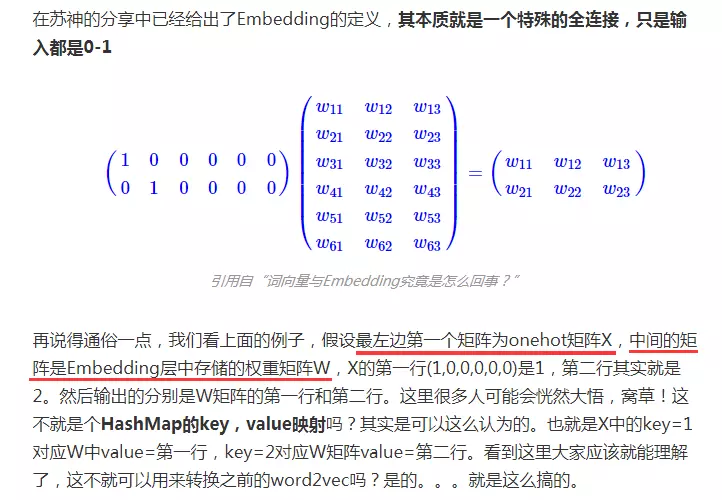


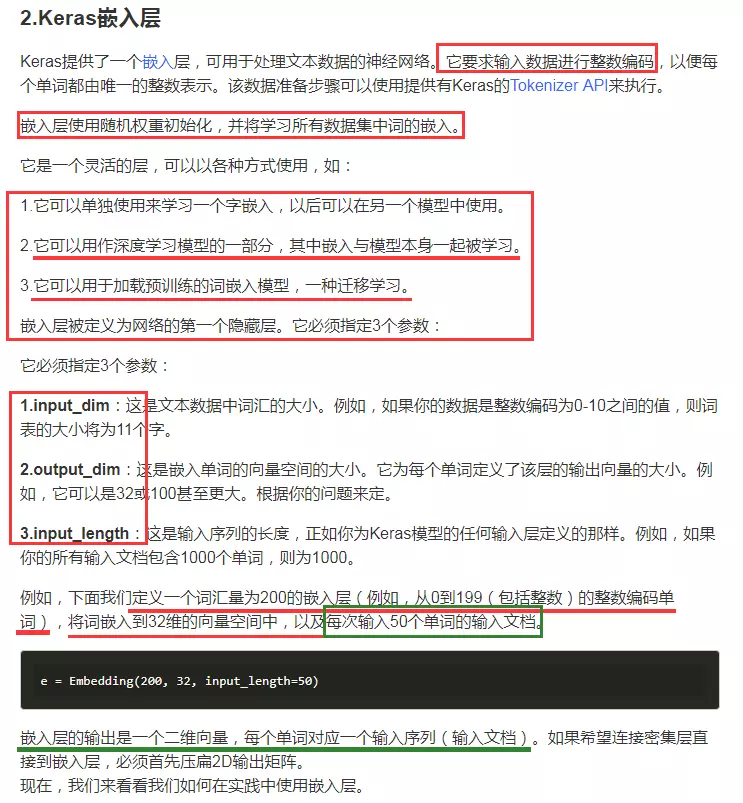

In [6]:
# 数据预处理
seq_len = 100
batch_size = 64
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=seq_len)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,maxlen=seq_len)

db_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(1000).batch(batch_size,drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(1000).batch(batch_size,drop_remainder=True)

In [23]:
# 构建 multi-layer RNN
class MyRNN(tf.keras.models.Model):
    def __init__(self,batch_sz,embedding_len = 128):
        super(MyRNN,self).__init__()
        # 定义Embedding层、fc层、SimpleRNN层
        self.unit = 64
        self.embedding = layers.Embedding(10000,embedding_len,input_length=seq_len)
        self.SimpleRNN_1 = layers.SimpleRNNCell(self.unit)
        self.SimpleRNN_2 = layers.SimpleRNNCell(self.unit)
        self.fc = layers.Dense(1,activation=tf.nn.sigmoid)
        # 0时刻的h0、h1
        self.h0 = [tf.zeros([batch_sz,self.unit])]
        self.h1 = [tf.zeros([batch_sz,self.unit])]
        
    def call(self,inputs,training = None):
        vec = self.embedding(inputs) # batch_size,seq_len,embedding_len
        h0 = self.h0
        h1 = self.h1
        for embedding in tf.unstack(vec,axis=1):
            out1,h0 = self.SimpleRNN_1(embedding,h0)
            out2,h1 = self.SimpleRNN_2(out1,h1)
        prob = self.fc(out2)
        return prob
    

In [24]:
# train
epochs = 3
model = MyRNN(batch_size)
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
             loss = losses.BinaryCrossentropy(),
             metrics = ['accuracy'])

model.fit(db_train,epochs=epochs,validation_data = db_test)
model.summary()

Epoch 1/3
390/390 [==============================] - 30s 77ms/step - loss: 0.5477 - accuracy: 0.5948 - val_loss: 0.4451 - val_accuracy: 0.8070
Epoch 2/3
390/390 [==============================] - 22s 56ms/step - loss: 0.3342 - accuracy: 0.8435 - val_loss: 0.4586 - val_accuracy: 0.7915
Epoch 3/3
390/390 [==============================] - 22s 56ms/step - loss: 0.1825 - accuracy: 0.9193 - val_loss: 0.5672 - val_accuracy: 0.7988
Model: "my_rnn_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  1280000   
_________________________________________________________________
simple_rnn_cell_8 (SimpleRNN multiple                  12352     
_________________________________________________________________
simple_rnn_cell_9 (SimpleRNN multiple                  8256      
_________________________________________________________________
dense_4 (Dense)          

In [29]:
model.save_weights('./ckpt/save_2357')


In [31]:
new_model = MyRNN(batch_size)
new_model.load_weights('./ckpt/save_2357')

In [33]:
new_model.compile(optimizer=optimizers.Adam(0.001),
                 loss = losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
new_model.evaluate(db_test)

390/390 [==============================] - 9s 22ms/step - loss: 0.5672 - accuracy: 0.7953


[0.5671904655603263, 0.7987981]